In [1]:
import itertools
import math
import random as rn
import re

import lightgbm as lgb
import optuna
import pandas as pd
from sklearn import preprocessing

In [2]:
df = pd.read_feather('./data/train.feather')

In [3]:
df['era'] = df.era.apply(lambda era: int(re.findall('era(\d+)$', era)[0]))

In [4]:
df.data_type.value_counts()

train         501808
validation    137779
Name: data_type, dtype: Int64

In [5]:
df.target.value_counts(dropna=False)

0.50    320631
0.25    127584
0.75    127578
1.00     31899
0.00     31895
Name: target, dtype: int64

In [6]:
def get_group_stats(df: pd.DataFrame) -> pd.DataFrame:
        for group in ["intelligence", "wisdom", "charisma", "dexterity", "strength", "constitution"]:
            cols = [col for col in df.columns if group in col]
            df[f"feature_{group}_mean"] = df[cols].mean(axis=1)
            df[f"feature_{group}_std"] = df[cols].std(axis=1)
            df[f"feature_{group}_skew"] = df[cols].skew(axis=1)
        return df

df = get_group_stats(df)

In [7]:
base_features = [f for f in df.columns if re.match('feature.+\d$', f)]
len(base_features)

310

In [8]:
grouped = itertools.groupby(base_features, lambda x:re.findall('_(.+?)\d+$', x)[0])
groups = {k: list(v) for k, v in grouped}

In [9]:
ft_corr_list = set()
interactions_count = 20
for k, v in groups.items():
    n = math.ceil(len(v) / len(base_features) * interactions_count)
    rn.seed(3)
    sample = rn.sample(v, n)
    print(k, sample)
    ft_corr_list |= set(sample)

intelligence ['feature_intelligence4']
charisma ['feature_charisma31', 'feature_charisma76', 'feature_charisma70', 'feature_charisma17', 'feature_charisma48', 'feature_charisma78']
strength ['feature_strength16', 'feature_strength38', 'feature_strength35']
dexterity ['feature_dexterity4']
constitution ['feature_constitution31', 'feature_constitution76', 'feature_constitution70', 'feature_constitution17', 'feature_constitution48', 'feature_constitution78', 'feature_constitution61', 'feature_constitution81']
wisdom ['feature_wisdom16', 'feature_wisdom38', 'feature_wisdom35']


In [10]:
interactions = preprocessing.PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

interactions.fit(df[ft_corr_list], df["target"])

df_interact = pd.DataFrame(interactions.transform(df[ft_corr_list]))

df=pd.concat([df,df_interact],axis=1)

In [11]:
corrtarget = df.groupby('era').apply(lambda x: x[base_features].corrwith(x.target))
corrtarget.columns = [f"{c}_corr" for c in corrtarget.columns]

corrtarget = corrtarget.reset_index()
corrtarget['era'] = corrtarget.era +1
corrtarget

,era,feature_intelligence1_corr,feature_intelligence2_corr,feature_intelligence3_corr,feature_intelligence4_corr,feature_intelligence5_corr,feature_intelligence6_corr,feature_intelligence7_corr,feature_intelligence8_corr,feature_intelligence9_corr,...,feature_wisdom37_corr,feature_wisdom38_corr,feature_wisdom39_corr,feature_wisdom40_corr,feature_wisdom41_corr,feature_wisdom42_corr,feature_wisdom43_corr,feature_wisdom44_corr,feature_wisdom45_corr,feature_wisdom46_corr
0,2,-0.013449,0.021977,0.029850,-0.011809,0.022633,-0.024273,-0.031818,-0.019681,0.031931,...,-0.022115,-0.021081,-0.011199,0.023029,0.020617,0.010317,0.015449,0.014562,-0.042133,-0.007230
1,3,-0.010667,0.032668,0.026001,0.003333,0.004000,-0.000667,-0.000334,-0.019001,0.018085,...,-0.012405,0.001675,0.004689,0.018586,0.002063,0.012850,0.011365,0.020651,0.004373,0.000668
2,4,-0.012404,-0.015016,-0.018606,-0.000979,-0.003591,0.008814,0.017954,-0.003591,0.018375,...,0.028219,0.034745,0.027862,0.005020,0.008391,0.023167,-0.010459,0.015729,-0.011540,-0.004900
3,5,-0.007157,0.015869,0.007468,-0.023337,-0.048540,0.012135,0.011202,-0.027693,0.007191,...,0.034410,0.031251,0.030939,-0.022632,-0.013421,0.030947,0.019638,-0.017851,0.011313,0.023978
4,6,-0.009741,-0.023025,-0.014169,-0.022730,0.026863,0.013579,0.018597,-0.004133,-0.014212,...,0.025209,0.025186,0.015704,0.003626,0.009695,0.031139,-0.015669,0.002115,0.003880,-0.001181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,209,-0.004019,0.030603,0.027202,-0.012365,-0.033848,-0.042658,-0.046677,0.002009,0.013047,...,0.006673,0.015649,0.013635,-0.014706,-0.014550,0.002014,-0.015313,-0.020589,-0.021258,0.002474
144,210,-0.003981,0.030624,0.030930,-0.007350,-0.016231,0.011484,0.015924,0.003522,0.002919,...,0.032882,0.030226,0.026390,-0.011652,-0.000153,0.003222,-0.020534,-0.003066,0.008692,-0.000766
145,211,0.005597,0.011194,0.014824,0.003933,-0.008017,-0.036001,-0.037211,0.009378,-0.019911,...,0.043707,0.033342,0.020763,0.014541,0.007116,0.024855,-0.000757,0.012875,-0.002076,-0.033900
146,212,-0.018404,-0.007757,-0.017796,0.019469,-0.002890,-0.034831,-0.031789,-0.013233,-0.017415,...,-0.036472,-0.033974,-0.028947,-0.054379,-0.039299,0.006094,0.013239,-0.058492,-0.010427,0.016891


In [12]:
train = df[df.data_type == 'train']
test = df[df.data_type == 'validation']

In [17]:
features = [f for f in df.columns if type(f) != int and f.startswith('feature') and not f.endswith('corr')]
#eatures = [f for f in df.columns if type(f) == int or (f.startswith('feature') and not f.endswith('corr'))]
len(features)

328

In [18]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr


def spearman(y_true, y_pred, axis=0):
    """ Calculate Spearman correlation """
    return spearmanr(y_true, y_pred, axis=axis)[0]


def sharpe(df: pd.DataFrame, y_pred) -> np.float32:
    """
    Calculate the Sharpe ratio by using grouped per-era data
    :param df: A Pandas DataFrame containing the columns "era", "target" and "prediction"
    :return: The Sharpe ratio for your predictions.
    """
    df = df.copy()
    df['prediction'] = y_pred
    def _score(sub_df: pd.DataFrame) -> np.float32:
        """ Calculate Spearman correlation for Pandas' apply method """
        return spearmanr(sub_df["target"], sub_df["prediction"])[0, 1]

    corrs = df.groupby("era").apply(_score)
    return corrs.mean() / corrs.std()

In [19]:
dtrain = lgb.Dataset(train[features], label=train.target)

param = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    "device": "gpu",
    "num_iterations": 2000,
    'learning_rate': 0.006085005910213603,
 'lambda_l1': 1.460802617273486,
 'lambda_l2': 1.0611461754655795e-05,
 'feature_fraction': 0.9969345315260029,
 'bagging_fraction': 0.5585536563609045,
 'bagging_freq': 1,
 'min_child_samples': 83,
 'num_leaves': 107,
 'max_depth': 15,
    'verbose': 1,
    "random_state": 0,
}

gbm = lgb.train(param, dtrain)
preds = gbm.predict(test[features])
accuracy = spearman(test.target, preds)

accuracy

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5347
[LightGBM] [Info] Number of data points in the train set: 501808, number of used features: 328
[LightGBM] [Info] Using GPU Device: GeForce GTX 1080 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 326 dense feature groups (156.97 MB) transferred to GPU in 0.051998 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.499997


0.02630967866222815

In [ ]:
0.025865630981665343

In [ ]:
def objective(trial):
    dtrain = lgb.Dataset(train[features], label=train.target)
 
    param = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'l2',
        "device": "gpu",
        "learning_rate": trial.suggest_uniform('learning_rate', 0.004, 0.1),
        "num_iterations": 500,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.1, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.1, 10.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        "max_depth": trial.suggest_int('max_depth', 3, 20),
        'verbose': -1,
    }
 
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(test[features])
    accuracy = spearman(test.target, preds)
    return accuracy
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [10]:
study.best_trial.params

{'learning_rate': 0.006085005910213603,
 'lambda_l1': 1.460802617273486,
 'lambda_l2': 1.0611461754655795e-05,
 'feature_fraction': 0.9969345315260029,
 'bagging_fraction': 0.5585536563609045,
 'bagging_freq': 1,
 'min_child_samples': 83,
 'num_leaves': 107,
 'max_depth': 15}

In [20]:
accuracy

0.0133659670894086

## Model

### LightGBM

In [20]:
meta = ['id', 'era', 'data_type', 'target', 'prediction']
feature_columns = features

In [21]:
len(feature_columns)

328

In [27]:
%%time

dtrain = lgb.Dataset(train[feature_columns].fillna(0), label=train["target"])
dvalid = lgb.Dataset(test[feature_columns].fillna(0), label=test["target"])


param = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    "device": "gpu",
    "num_iterations": 2000,
    'learning_rate': 0.006085005910213603,
 'lambda_l1': 1.460802617273486,
 'lambda_l2': 1.0611461754655795e-05,
 'feature_fraction': 0.9969345315260029,
 'bagging_fraction': 0.5585536563609045,
 'bagging_freq': 1,
 'min_child_samples': 83,
 'num_leaves': 107,
 'max_depth': 15,
    'verbose': 1,
    "random_state": 0,
}

model = lgb.train(param, dtrain)

train.loc[:, "prediction"] = model.predict(train[feature_columns])

In [30]:
test.loc[:,"prediction"] = model.predict(test[feature_columns])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

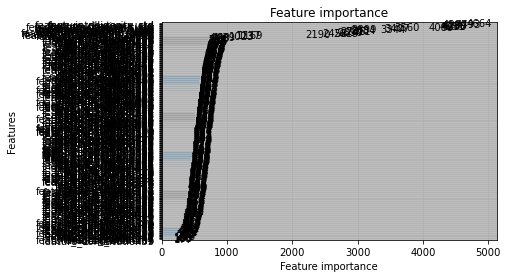

In [31]:
lgb.plot_importance(model)

## Evaluation

In [34]:

from sklearn.metrics import mean_absolute_error

def sharpe_ratio(corrs: pd.Series) -> np.float32:
        """
        Calculate the Sharpe ratio for Numerai by using grouped per-era data

        :param corrs: A Pandas Series containing the Spearman correlations for each era
        :return: A float denoting the Sharpe ratio of your predictions.
        """
        return corrs.mean() / corrs.std()


def evaluate(df: pd.DataFrame) -> tuple:
        """
        Evaluate and display relevant metrics for Numerai 

        :param df: A Pandas DataFrame containing the columns "era", "target" and a column for predictions
        :param pred_col: The column where the predictions are stored
        :return: A tuple of float containing the metrics
        """
        def _score(sub_df: pd.DataFrame) -> np.float32:
            """Calculates Spearman correlation"""
            return spearmanr(sub_df["target"], sub_df["prediction"])[0]

        # Calculate metrics
        corrs = df.groupby("era").apply(_score)
        print(corrs)
        payout_raw = (corrs / 0.2).clip(-1, 1)
        spearman = round(corrs.mean(), 4)

        payout = round(payout_raw.mean(), 4)
        numerai_sharpe = round(sharpe_ratio(corrs), 4)
        mae = mean_absolute_error(df["target"], df["prediction"]).round(4)

        # Display metrics
        print(f"Spearman Correlation: {spearman}")
        print(f"Average Payout: {payout}")
        print(f"Sharpe Ratio: {numerai_sharpe}")
        print(f"Mean Absolute Error (MAE): {mae}")
        return spearman, payout, numerai_sharpe, mae
        
feature_spearman_val = [spearmanr(test["prediction"], test[f])[0] for f in feature_columns]
feature_exposure_val = np.std(feature_spearman_val).round(4)
spearman, payout, numerai_sharpe, mae = evaluate(test)

era
121    0.038342
122    0.026930
123    0.048853
124    0.055559
125    0.029151
126    0.038846
127    0.005870
128    0.057918
129   -0.018374
130    0.057636
131    0.022801
132    0.073294
197    0.037282
198    0.012333
199   -0.044739
200   -0.005282
201    0.002306
202    0.050141
203    0.034553
204    0.049194
205    0.006324
206   -0.008602
207    0.044040
208    0.073049
209    0.053856
210   -0.014284
211   -0.012686
212    0.024565
dtype: float64
Spearman Correlation: 0.0264
Average Payout: 0.1319
Sharpe Ratio: 0.8772
Mean Absolute Error (MAE): 0.1543


## Submission CSV

In [36]:
%%time
import os
import random as rn

import lightgbm as lgb
import matplotlib.pyplot as plt
import numerapi
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error

example_public_id = "WUTL537K2HLISXIDDHFTQF2LZ5MO67HV"
example_secret_key = "3EKVW2XQ7NTR6FDA77ZOJF4UWHOE56QYZ7VZ7CZ5WYVIMEARXEUNELYXOPH4S35J"
NAPI = numerapi.NumerAPI(example_public_id, example_secret_key)


DIR = "data"


def download_current_data(directory: str):
    """
        Downloads the data for the current round
        :param directory: The path to the directory where the data needs to be saved
        """
    current_round = NAPI.get_current_round()
    if os.path.isdir(f"{directory}/numerai_dataset_{current_round}/"):
        print(f"You already have the newest data! Current round is: {current_round}")
    else:
        print(f"Downloading new data for round: {current_round}!")
        NAPI.download_current_dataset(dest_path=directory, unzip=True)


def load_data(directory: str, reduce_memory: bool = True) -> tuple:
    """
        Get data for current round
        :param directory: The path to the directory where the data needs to be saved
        :return: A tuple containing the datasets
        """
    print("Loading the data")
    full_path = f"{directory}/numerai_dataset_{NAPI.get_current_round()}/"
    train_path = full_path + "numerai_training_data.csv"
    test_path = full_path + "numerai_tournament_data.csv"
    train = pd.read_csv(train_path, encoding='ascii')
    test = pd.read_csv(test_path, encoding='ascii')
    # Reduce all features to 32-bit floats
    if reduce_memory:
        num_features = [f for f in train.columns if f.startswith("feature")]
        train[num_features] = train[num_features].astype(np.float32)
        test[num_features] = test[num_features].astype(np.float32)
    val = test[test["data_type"] == "validation"]
    test = test[test["data_type"] != "validation"]
    return train, val, test


# Download, unzip and load data
download_current_data(DIR)
train, val, test = load_data(DIR, reduce_memory=True)

You already have the newest data! Current round is: 254
Loading the data
CPU times: user 1min 36s, sys: 1min 11s, total: 2min 48s
Wall time: 2min 50s


In [37]:
def get_group_stats(df: pd.DataFrame) -> pd.DataFrame:
        for group in ["intelligence", "wisdom", "charisma", "dexterity", "strength", "constitution"]:
            cols = [col for col in df.columns if group in col]
            df[f"feature_{group}_mean"] = df[cols].mean(axis=1)
            df[f"feature_{group}_std"] = df[cols].std(axis=1)
            df[f"feature_{group}_skew"] = df[cols].skew(axis=1)
        return df

train = get_group_stats(train)
val = get_group_stats(val)
test = get_group_stats(test)

In [40]:
feature_list = feature_columns

test.loc[:, "prediction"] = model.predict(test[feature_list])
val.loc[:, "prediction"] = model.predict(val[feature_list])
test[['id', "prediction"]].to_csv("submission_test.csv", index=False)

val[['id', "prediction"]].to_csv("submission_val.csv", index=False)

test=0
val=0

directory = "data"
full_path = f'{directory}/numerai_dataset_{NAPI.get_current_round()}/'

test_path = full_path + 'numerai_tournament_data.csv'

tournament_data = pd.read_csv(test_path)
tournament_data_id=tournament_data['id']
tournament_data_id2=tournament_data['feature_dexterity7']
tournament_data_id=pd.concat([tournament_data_id,tournament_data_id2],axis=1)

In [41]:
val=pd.read_csv("submission_val.csv")
test=pd.read_csv("submission_test.csv")

test_val_concat=pd.concat([val[['id', "prediction"]],test[['id', "prediction"]]],axis=0).set_index('id')
tournament_data_id=tournament_data_id.set_index('id')

conc_submit=pd.concat([tournament_data_id,test_val_concat],axis=1).drop(columns='feature_dexterity7').reset_index()
conc_submit=conc_submit.rename(columns={'index': 'id'})
conc_submit.to_csv("submission_file"+".csv", index=False)

In [42]:
def neutralize(series,by, proportion):
    scores = series.values.reshape(-1, 1)
    exposures = by.values.reshape(-1, 1)
    exposures = np.hstack((exposures, np.array([np.mean(series)] * len(exposures)).reshape(-1, 1)))
    correction = proportion * (exposures.dot(np.linalg.lstsq(exposures, scores)[0]))
    corrected_scores = scores - correction
    neutralized = pd.Series(corrected_scores.ravel(), index=series.index)
    return neutralized
    
by=pd.read_csv('data/numerai_dataset_'+str(NAPI.get_current_round())+'/example_predictions.csv')

neut=pd.read_csv("submission_file.csv")
neut=pd.DataFrame({'prediction':neutralize(neut['prediction'],by['prediction'], 0.3)})

conc=pd.concat([by.drop(columns="prediction"),neut],axis=1)
conc.to_csv("neutralized_submission_file.csv", index=False)#submission file

<ipython-input-42-db7083cc578f>:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  correction = proportion * (exposures.dot(np.linalg.lstsq(exposures, scores)[0]))
